In [1]:
from glob import glob
from os.path import basename

import numpy as np
import CONAN3

##### ------------------------------------

The CONAN3 has 3 major classes that are used to store information about the input files and also perform computations.

They are:
- `load_lightcurves` : ingest lightcurve files and creates an object that is used to configure baseline and model parameters. It contains methods to configure the LCs for fitting such as:

    - `lc_baseline`
    - `add_GP`
    - `setup_transit_rv`
    - `transit_depth_variation`
    - `setup_occulation`
    - `limb_darkening`
    - `contamination_factors`
    - `stellar_parameters`
    
    
- `load_rvs` : same as above but for rvs
- `mcmc_setup` : object to hol mcmc configuration

These objects are then given as input to the `fit_data` function to perform sampling. 

Example

### light curve object

In [2]:
path = "/home/tunde/Dropbox/postdoc/work/wasp-127/PIPE/wasp-127_conanfit/new_lcs/"
lcs = sorted(glob(f"{path}w127*"))
lc_list = [basename(lc) for lc in lcs[:1]]

print(lc_list)

['w127_pipe1.txt']


In [3]:
lc_data = CONAN3.load_lightcurves(lc_list, path, filters = "CH1", lamdas=6000)
lc_data

Filters: ['CH1']
Order of unique filters: ['CH1']


Object containing 1 lightcurves
Files:['w127_pipe1.txt']
Filepath: /home/tunde/Dropbox/postdoc/work/wasp-127/PIPE/wasp-127_conanfit/new_lcs/

- The lc_data object holds information now about the light curves. The light curves can be plotted using the `plot` method of the object.

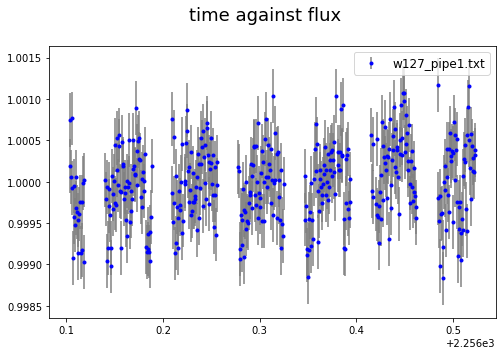

In [4]:
lc_data.plot()

- correlations between the flux and other columns in the lightcurve file can be visualized by specifying the columns to plot. e.g. to plot column5 (roll angle) against column 1 (flux)

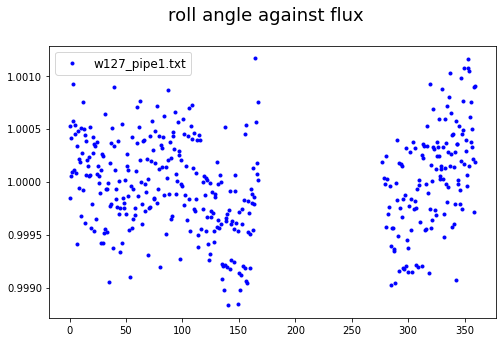

In [5]:
lc_data.plot(plot_cols=(5,1), col_labels=("roll angle","flux"))

- the baseline model for each lightcurve in the lc_data object can be defined using the `lc_baseline` 

the polynomial order for the cotrending vectors (t, x, y, phi, conta, bg/sky...) is specified for each lightcurve (lc) in lc_data. A list of equal to number of lcs is expected. if a single integer is given, the same is used for all lcs. "y" or "n" can be used to specify if an lc baseline should include a gp.

Error reporting will help catch most mistakes :)

*(t, x, y, phi, conta, bg/sky...)  correspond to columns of the input data --> columns 0, 3 4,5,6,7 respectively. Any desired array can be put in these columns to decorrelate against them irrespective of the name here (which would be modified soon)



In [6]:
lc_data.lc_baseline(dt = 2, dy=2, dx=0, gp="y")

#---------------------------- # Input lightcurves filters baseline function-------------- 
name           	fil	 lamda	 time	 roll	 x	 y	 conta	 sky	 sin	 group	 id	 GP
w127_pipe1.txt 	CH1	6000.0	    2	   0	 0	 2	     0	   0	   0	     0	  1	 y 


In [7]:
gp_lcs = list(lc_data._gp_lcs)
gp_lcs

['w127_pipe1.txt']

- add GPs to specified lcs. only lcs with GP = 'y' above can be included.

the independent variable of the gp can be any of ["time", "xshift", "yshift", "air", "fwhm", "sky"] again corresponding to columns of the input data --> columns 0, 3 4,5,6,7. to be changed soon 

the `pars` argument specifies the independent gp variable for each lc by taking a list of strings from the options above. if  single string is given, same independent variable is used for all specified lcs. To apply a two dimensional GP on an lc, the file name must be given twice and the corresponding `pars` value will specify the variable of the different dimensions.

similarly `kernels` argument specifies the kernel for each specified lc

The `log_scale` and `log_metric` arguments specify the prior of the variance and lengthscale of the GP kernel applied for each specified lc. It is given as follows:
* if tuple is of len 2, set normal prior with index[0] as prior mean and index[1] as prior width.
* if tuple is of len 3, set uniform prior with between index[0] and index[2], index[1] is the initial value.

if a single tuple is given, same prior is used for all specified lcs


To apply a 2D GP to the first lc and 1D to the third:

In [8]:
gp_list = gp_lcs*2
gp_list

['w127_pipe1.txt', 'w127_pipe1.txt']

In [9]:
lc_data.add_GP(lc_list = gp_list,
               pars = ["air","time"],
               kernels = ["mat32","sqexp"],
               log_scale = (-25,-17.83,-10),
               log_metric = [(0,7.7,20), (0,7,20)],
               verbose = True)

# -------- photometry GP input properties: komplex kernel -> several lines -------------- 
name          para  kernel WN scale   s_step s_pri s_pri_wid s_up  s_lo  metric  m_step m_pri  m_pri_wid m_up m_lo
w127_pipe1.txt air   mat32  y  1.8e-08 0.0010 -17.8  0.00e+00 -10.0 -25.0 2.2e+03 0.0010  7.70  0.00e+00 20.0  0.0
w127_pipe1.txt time  sqexp  y  1.8e-08 0.0010 -17.8  0.00e+00 -10.0 -25.0 1.1e+03 0.0010  7.00  0.00e+00 20.0  0.0


### Transit parameters

The model paramters are: ['RpRs', 'Impact_para', 'Duration', 'T_0', 'Period', 'Eccentricity', 'Omega', 'K']

The parameters can be defined in following ways:

* fixed value as float or int, e.g Period = 3.4
* free parameter with gaussian prior given as tuple of len 2, e.g. T_0 = (5678, 0.1)
* free parameters with uniform prior interval and initial value given as tuple of length 3, e.g. RpRs = (0,0.1,0.2) with 0.1 being the initial value.

In [10]:
lc_data.setup_transit_rv(RpRs = 0.10104, Period=4.17806203,
                        Impact_para = 0.29, Duration=0.18137,
                        T_0 = (808.60255046,0.00031))

#=========== jump parameters (Jump0value step lower_limit upper_limit priors) ====================== 
name        	fit	start_val	stepsize	low_lim	up_lim	prior	value	sig_lo	sig_hi
RpRs        	n  	 0.10104	0.0000000	0.00	1.00	n	0.10104	0.0e+00	0.0e+00 
Impact_para 	n  	 0.29000	0.0000000	0.00	1.00	n	0.29000	0.0e+00	0.0e+00 
Duration    	n  	 0.18137	0.0000000	0.00	1.00	n	0.18137	0.0e+00	0.0e+00 
T_0         	y  	808.60255	0.0000031	0.00	10000.00	p	808.60255	3.1e-04	3.1e-04 
Period      	n  	 4.17806	0.0000000	0.00	10000.00	n	4.17806	0.0e+00	0.0e+00 
Eccentricity	n  	 0.00000	0.0000000	0.00	1.00	n	0.00000	0.0e+00	0.0e+00 
omega       	n  	90.00000	0.0000000	0.00	360.00	n	90.00000	0.0e+00	0.0e+00 
K           	n  	 0.00000	0.0000000	0.00	10000.00	n	0.00000	0.0e+00	0.0e+00 


In [11]:
#time, flux, err, xshift, yshift, roll, thermfront2, bg, exp

#### optional configurations

In [12]:
lc_data.transit_depth_variation()

#=========== ddF setup ============================================================================== 
Fit_ddFs  step	 low_lim   up_lim   prior   sig_lo   sig_hi   div_white
n         0.001	 -1.0000   1.0000   n       0.00000   0.00000   n  
group_ID   RpRs_0   err		dwfile
     1	   0.1000   1.00e-04   dw_001.dat


In [13]:
lc_data.setup_occultation("all")

fitting occultation depth for filters: ['CH1']

=========== occultation setup ============================================================================= 
filters	fit start_val	stepsize  low_lim  up_lim  prior  value      sig_lo 	sig_hi 
CH1    	y   0.00050000	0.0000100    0.000   0.001  n      0.000e+00  0.00e+00	0.00e+00 


In [14]:
lc_data.limb_darkening(c1=0)

#=========== Limb darkending setup ===================================================================
filters priors	c_1  step1  low_lim1  up_lim1	c_2  step2 low_lim2 up_lim2
CH1     n     	0.000 0.001  0.0000  0.0000	0.000 0.001  0.0000  0.0000


In [15]:
lc_data.contamination_factors()

#=========== contamination setup === give contamination as flux ratio ================================
filters	contam	err
CH1    	0.0000	0.0000


In [16]:
lc_data.stellar_parameters()

#=========== Stellar input properties ================================================================
# parameter    value  sig_lo  sig_hi 
Radius_[Rsun]  1.000  0.010  0.010 
Mass_[Msun]    1.000  0.010  0.010
Stellar_para_input_method:_R+rho_(Rrho),_M+rho_(Mrho),_M+R_(MR): MR


In [17]:
lc_data

Object containing 1 lightcurves
Files:['w127_pipe1.txt']
Filepath: /home/tunde/Dropbox/postdoc/work/wasp-127/PIPE/wasp-127_conanfit/new_lcs/

In [18]:
lc_data.print()

#---------------------------- # Input lightcurves filters baseline function-------------- 
name           	fil	 lamda	 time	 roll	 x	 y	 conta	 sky	 sin	 group	 id	 GP
w127_pipe1.txt 	CH1	6000.0	    2	   0	 0	 2	     0	   0	   0	     0	  1	 y 
# -------- photometry GP input properties: komplex kernel -> several lines -------------- 
name          para  kernel WN scale   s_step s_pri s_pri_wid s_up  s_lo  metric  m_step m_pri  m_pri_wid m_up m_lo
w127_pipe1.txt air   mat32  y  1.8e-08 0.0010 -17.8  0.00e+00 -10.0 -25.0 2.2e+03 0.0010  7.70  0.00e+00 20.0  0.0
w127_pipe1.txt time  sqexp  y  1.8e-08 0.0010 -17.8  0.00e+00 -10.0 -25.0 1.1e+03 0.0010  7.00  0.00e+00 20.0  0.0
#=========== jump parameters (Jump0value step lower_limit upper_limit priors) ====================== 
name        	fit	start_val	stepsize	low_lim	up_lim	prior	value	sig_lo	sig_hi
RpRs        	n  	 0.10104	0.0000000	0.00	1.00	n	0.10104	0.0e+00	0.0e+00 
Impact_para 	n  	 0.29000	0.0000000	0.00	1.00	n	0.29000	0.0e+00	0.0e

### RV data if available

In [19]:
# rvs= sorted(glob(f"{path}rv*"))
# rv_list = [basename(rv) for rv in rvs]
# print(rv_list)

In [20]:
rv_data= CONAN3.load_rvs()
rv_data

Object containing 0 rvs
Files:[]
Filepath: /home/tunde/Dropbox/postdoc/work/CONAN3

In [21]:
rv_data.plot()

No data to plot


In [22]:
rv_data.rv_baseline()

# ------------------------------------------------------------
# Input RV curves, baseline function, gamma  
name            time  bis  fwhm  contrast  gamma_kms  stepsize  prior  value  sig_lo  sig_hi


In [23]:
print(rv_data._print_rv_baseline)

# ------------------------------------------------------------
# Input RV curves, baseline function, gamma  
name            time  bis  fwhm  contrast  gamma_kms  stepsize  prior  value  sig_lo  sig_hi


### setup mcmc object

In [24]:
mcmc = CONAN3.mcmc_setup()

#=========== MCMC setup ==============================================================================
Total_no_steps           128000 
Number_chains            64 
Number_of_processes      2 
Burnin_length            500 
Walk_(snooker/demc/mrw)  None 
GR_test_(y/n)            y 
Make_plots_(y/n)         n 
leastsq_(y/n)            y 
Savefile                 output_ex1.npy 
Savemodel                n 
Adapt_base_stepsize      y 
Remove_param_for_CNM     n 
leastsq_for_basepar      n 
lssq_use_Lev-Marq        n 
apply_CFs                y 
apply_jitter             y


In [25]:
print(mcmc._print_mcmc_pars)

#=========== MCMC setup ==============================================================================
Total_no_steps           128000 
Number_chains            64 
Number_of_processes      2 
Burnin_length            500 
Walk_(snooker/demc/mrw)  None 
GR_test_(y/n)            y 
Make_plots_(y/n)         n 
leastsq_(y/n)            y 
Savefile                 output_ex1.npy 
Savemodel                n 
Adapt_base_stepsize      y 
Remove_param_for_CNM     n 
leastsq_for_basepar      n 
lssq_use_Lev-Marq        n 
apply_CFs                y 
apply_jitter             y


- create a config file from defined parameters

In [26]:
CONAN3.create_configfile(lc_data, rv_data, mcmc,
                         filename='input_config.dat')

#### finally fit using the 3 objects

In [ ]:
CONAN3.fit_data(lc_data, rv_data, mcmc)